## A/BTESTING

A survey is being conducted to determine whether a SmartAd that contains creative featureshas greater impact in creating brand awareness compared to a dummy advertisement.
Two groups of people are chosen randomly, the control group is shown the dummy ad while the exposed group is shown the SmartAd.
A survey is conducted to determine if the SmartAd had a greater impact than the dummy ad.

Hypothesis:

H0: p(SmartAd)=p(DummyAd)

H1: p(SmartAd)>p(DummyAd)

This analysis will conduct th one-sided hypothesis test above using classical A/B hypothesis tests, sequential A/B hypothesis test and machine learning A/B hypothesis test to determine whether the SmartAd had a statistically significant impact in creating awareness of the brand.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import math
from sklearn.preprocessing import LabelEncoder


In [2]:
Ad_data=pd.read_csv('D:/Stella/Documents/10_Academy/Week-2/AdSmartABdata.csv')
Ad_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [3]:
data=Ad_data.copy()

The first step is to clean the data and conduct an exploratory analysis of the variables contained in the dataset.

In [4]:
# number of data points
print(f" There are {data.shape[0]} rows and {data.shape[1]} columns")

 There are 8077 rows and 9 columns


In [5]:
#Total percent of missing values per column
def missing_per_column(df):
    print(round(df.isna().sum()))
missing_per_column(data)

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [7]:
#convert date column to date type
data['date'] =  pd.to_datetime(data['date'], format='%Y-%m-%d')

In [8]:
#check if auction id is unique
data['auction_id'].nunique()

8077

# Filter the dataset to get data on the people who responded
Check to see if there are people who failed to respond to the survey. The shape of the dataset reduces as shown below.
This indicates that some people did not respond to the survey. The exploratory analysis will look at the characteristics of people who responded to the survey and compare with people who did not take part in the survey.
The exploratory analysis will also look at the characteristics of people in the control group and compare with people in the exposed group for the people that responded to the survey.

In [9]:
response=data[(data['yes']== 1) | (data['no']== 1)].reset_index(drop=True)
response.shape

(1243, 9)

# Filter the dataset to get data on people who did not respond
There are more people who failed to respond to the survey compared to those who responded

In [10]:
non_response=data[(data['yes']== 0) & (data['no']== 0)].reset_index(drop=True)
non_response.shape

(6834, 9)

# Get dataset of the exposed group out of the people that responded

In [11]:
#exposed_data=response[(response['experiment']== 'exposed')]
exposed_data=response[(response['experiment']== 'exposed')].reset_index(drop=True)
exposed_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
3,013e45cf-e388-46a4-9c5b-a34303613940,exposed,2020-07-10,2,Generic Smartphone,6,Chrome Mobile,0,1
4,01905bae-fc59-475e-b2b4-09b78163c961,exposed,2020-07-05,6,I3312,6,Chrome Mobile WebView,0,1


# Get dataset of control group out of the people that responded

In [12]:
#control_data=response[(response['experiment']== 'control')]
control_data=response[(response['experiment']== 'control')].reset_index(drop=True)

# Univariate Analysis of people who responded vs people who failed to respond

In [13]:
#exposed_full_data=response[(response['experiment']== 'exposed')]

In [14]:
#control_full_data=response[(response['experiment']== 'control')]

In [15]:
response.yes.value_counts()

0    671
1    572
Name: yes, dtype: int64

In [16]:
#Number of respondents in the control and exposed groups
#There are more respondents in the exposed group than control group
response.experiment.value_counts()

exposed    657
control    586
Name: experiment, dtype: int64

Pivot table comparing the two groups of respondents. The rate at which respondents gain awareness of the brand from the smart and dummy ad is 0.47 and 0.45 respectively. Hyypothesis tests are conducted to determine whether this difference happened by chance or the SmartAd actually did a better job in creating brand awareness. The hypothesis test will quantify how confidently we can declare that the SmartAd is better. 

In [17]:
ab_summary = response.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total'] = response.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['rate'] = response.pivot_table(values='yes', index='experiment')
ab_summary

,yes,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


The graph below shows the no of people who said yes v/s no among respondents. In both groups of the experiment, the number of people who said no is higher than the number of people who said yes.

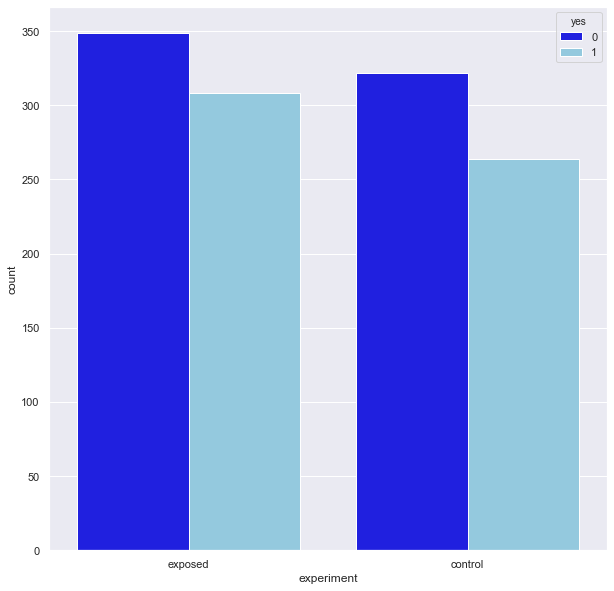

In [18]:
plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="experiment", palette=["blue", "skyblue"], data=response, hue='yes')

Bar plot of the responses per day shows the number of people responding to the question for each day of the experiment.
On the first day of the experiment the respones from the control group were higher but the trend changed after the first day. 
A similar trend is observed for non-respondents, most of them saw the survey on the first day.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

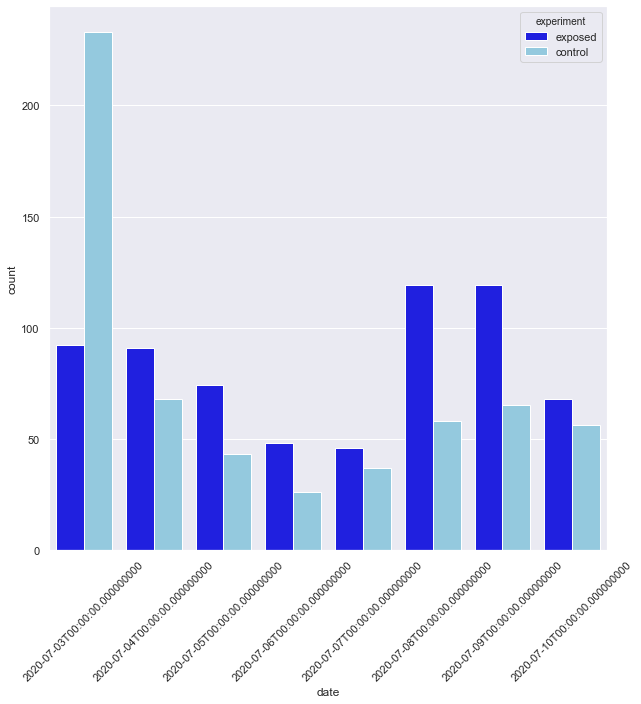

In [19]:
plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="date", palette=["blue", "skyblue"], data=response, hue='experiment')
plt.xticks(rotation=45)

bar plot of control vs experiment non-responses on the different days

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

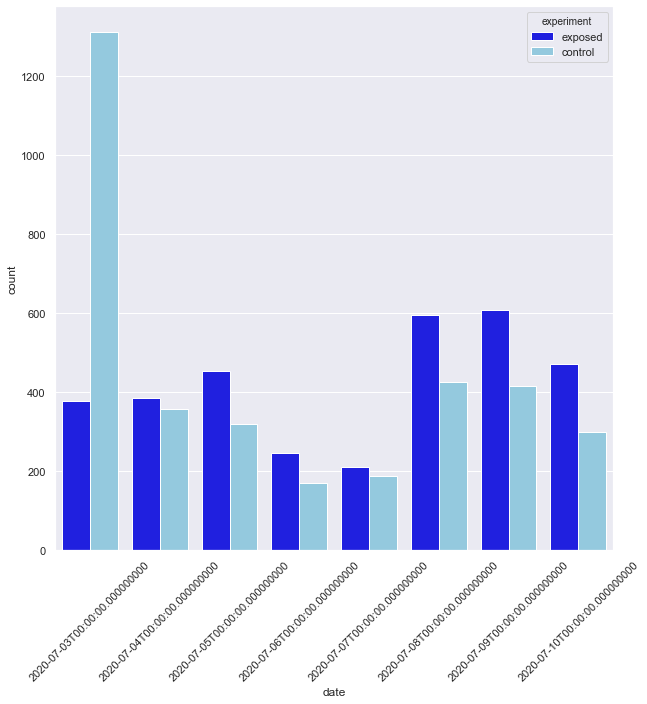

In [20]:
plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="date", palette=["blue", "skyblue"], data=non_response, hue='experiment')
plt.xticks(rotation=45)

bar plot of when the responses were made to determine which hour most people are online. Most people were online during hour 15 for both espondents and non-respondents. The trend is quite similar for both groups.

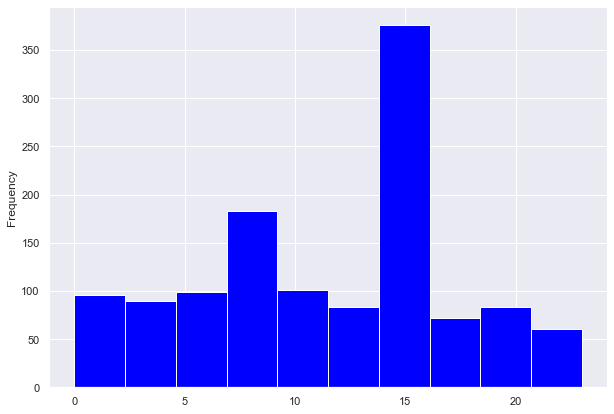

In [21]:
response.hour.plot(kind='hist', color='blue', figsize=(10,7))

Distribution of the hour the non-response was recorded

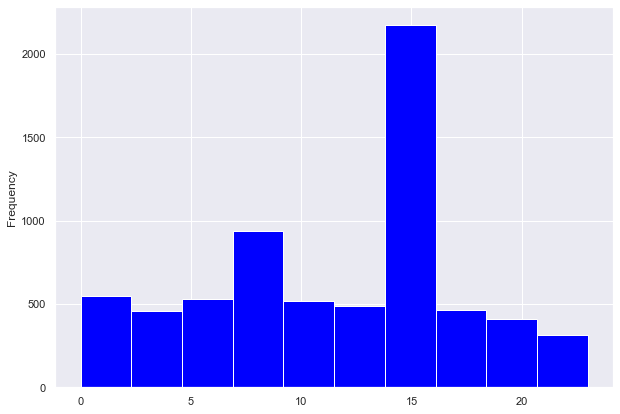

In [22]:
non_response.hour.plot(kind='hist', color='blue', figsize=(10,7))

response hour based on type of experiment

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

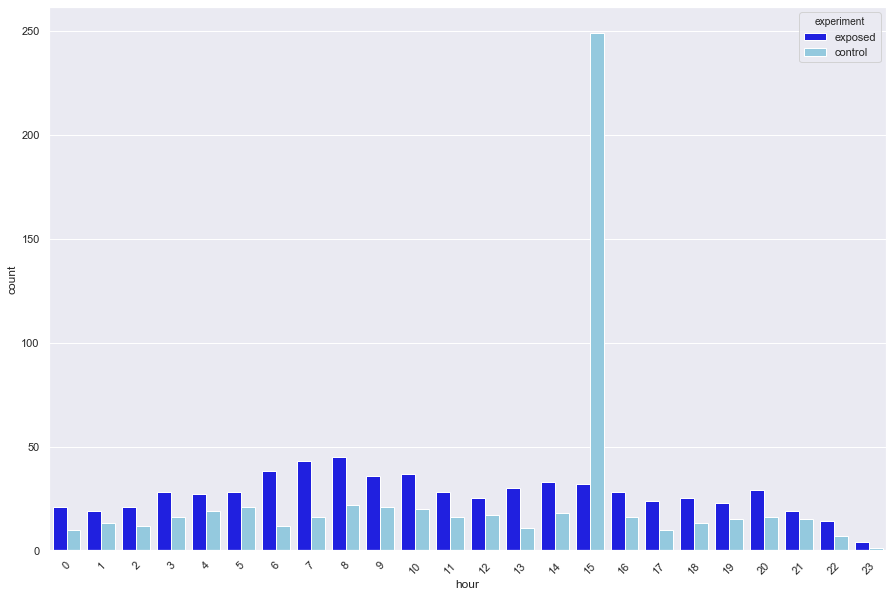

In [23]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="hour", palette=["blue", "skyblue"], data=response, hue='experiment')
plt.xticks(rotation=45)

non-respose hour based on experiment

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

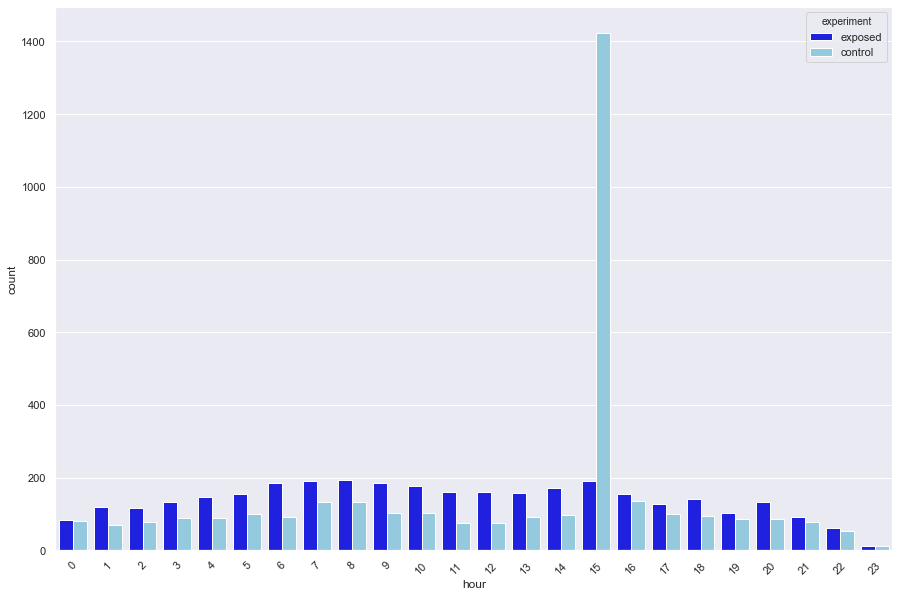

In [24]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="hour", palette=["blue", "skyblue"], data=non_response, hue='experiment')
plt.xticks(rotation=45)

Distribution of broswer for people who responded.

Most of the people who responded to the survey were using chrome mobile browser and most of the non-resondents saw the survey on chrome mobile too.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

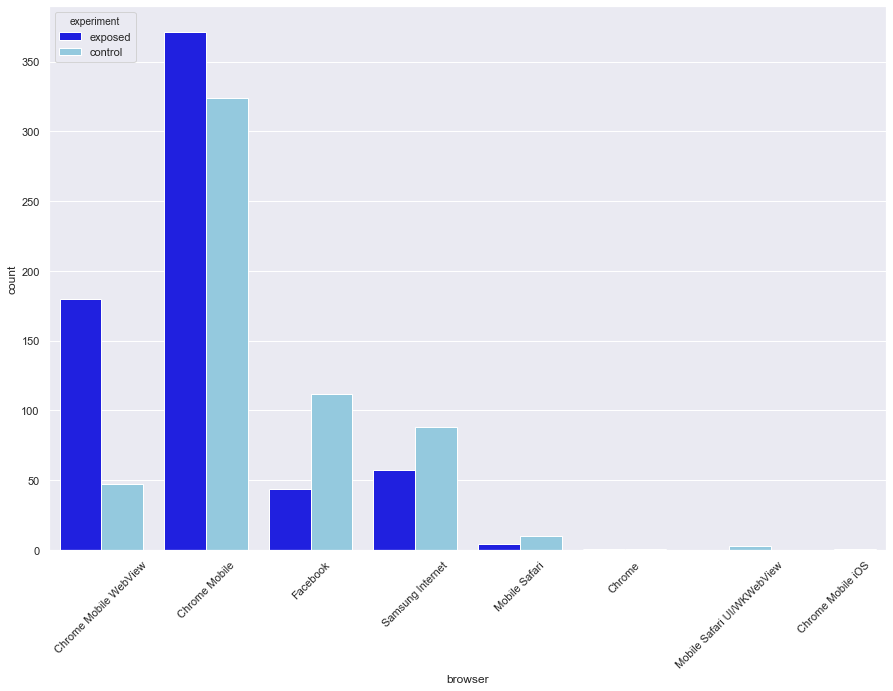

In [25]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="browser", palette=["blue", "skyblue"], data=response, hue='experiment')
plt.xticks(rotation=45)

Distribution of broswer for non-response

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

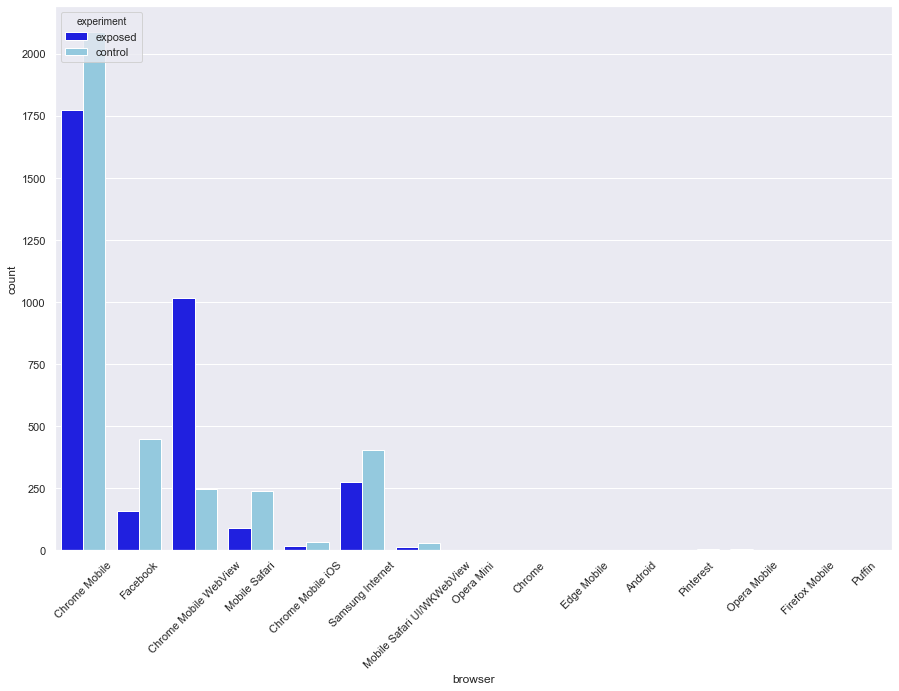

In [26]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="browser", palette=["blue", "skyblue"], data=non_response, hue='experiment')
plt.xticks(rotation=45)

Distribution of OS of respondents

Both respondents and non-respondent have a maority of people using OS 6

(array([0, 1]), <a list of 2 Text xticklabel objects>)

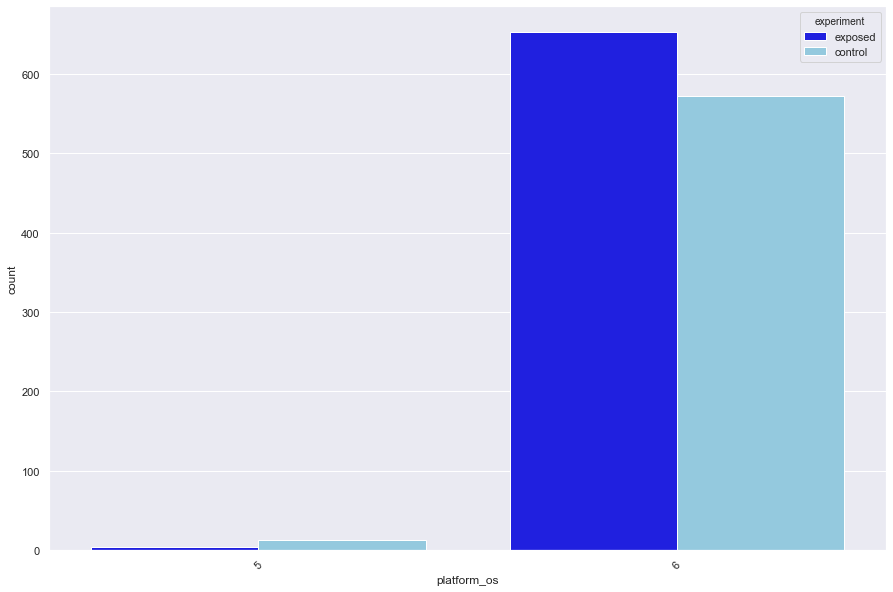

In [27]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="platform_os", palette=["blue", "skyblue"], data=response, hue='experiment')
plt.xticks(rotation=45)

Distribution of OS of non-respondents

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

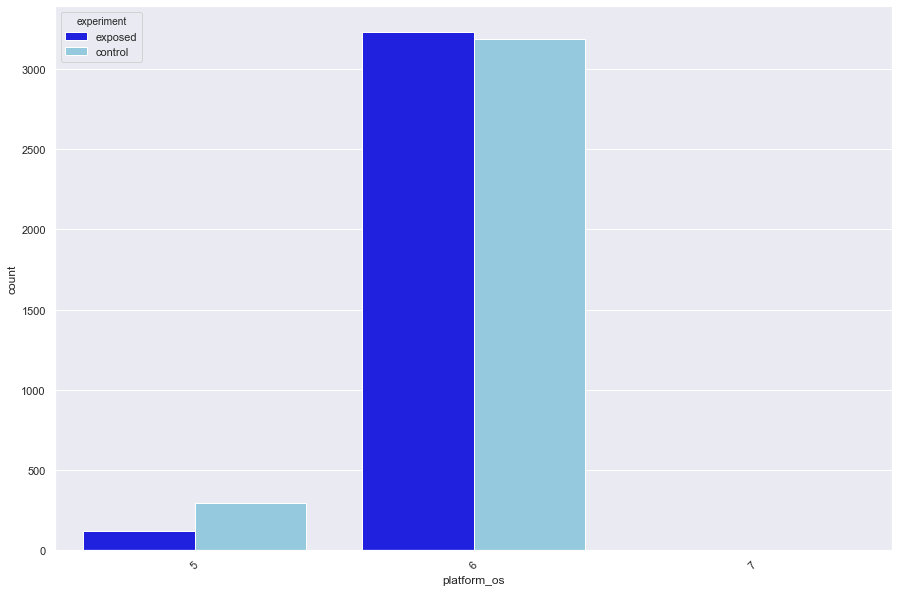

In [28]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="platform_os", palette=["blue", "skyblue"], data=non_response, hue='experiment')
plt.xticks(rotation=45)

Distribution of top 10 devices used by respondents

Both respondents and non-respondents majorly used a generic smartphone.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

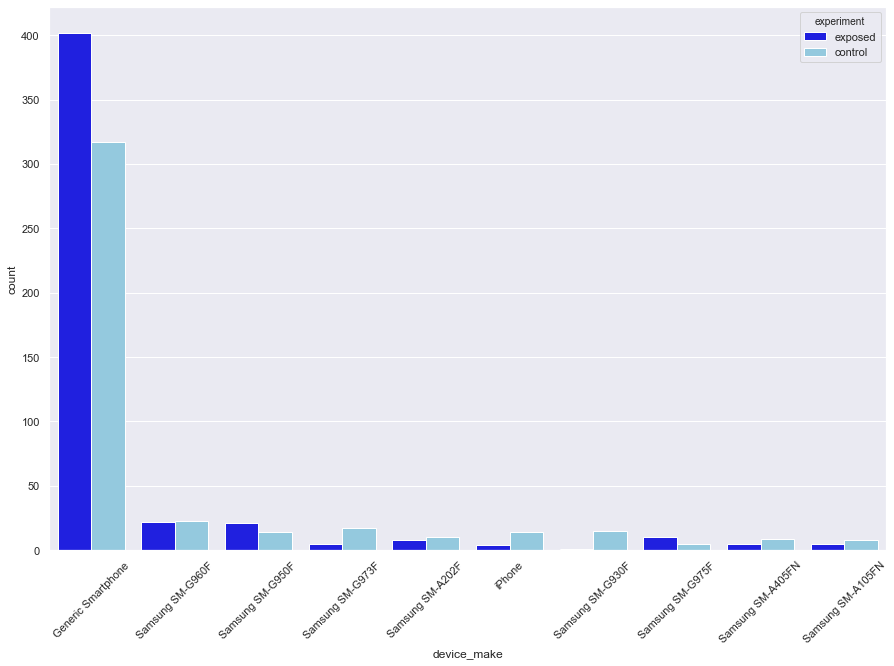

In [29]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="device_make", palette=["blue", "skyblue"], data=response, hue='experiment',order=response.device_make.value_counts().iloc[:10].index)
plt.xticks(rotation=45)

In [30]:
#Distribution of device of non-respondents

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

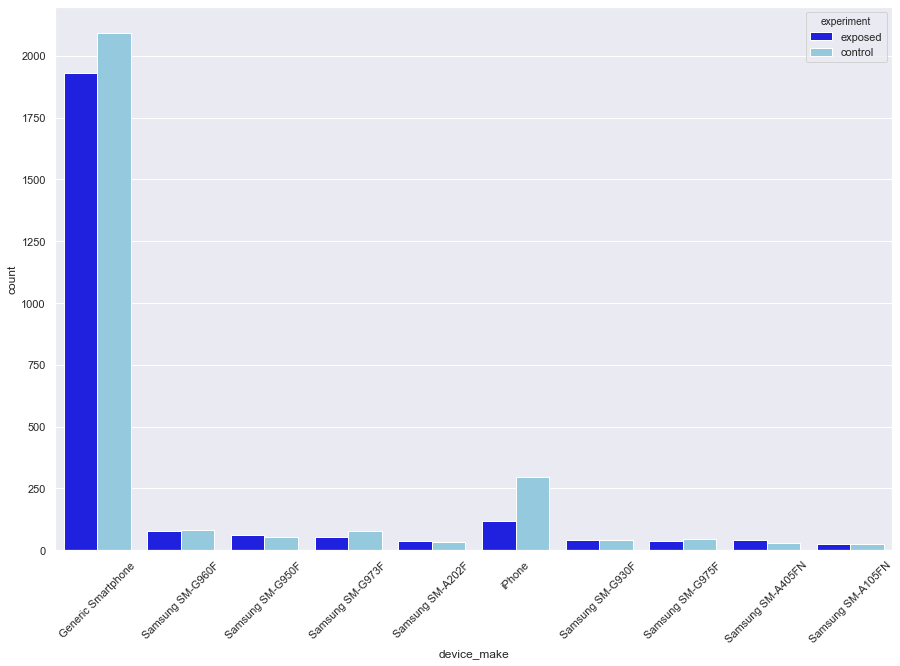

In [31]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="device_make", palette=["blue", "skyblue"], data=non_response, hue='experiment',order=response.device_make.value_counts().iloc[:10].index)
plt.xticks(rotation=45)

# Univariate analysis based on whether an individual knows the brand

bar plot of day of the experiment
on every date the people who did not know the brand were more than those who knew, 
the date of the experimrnt did not influence the number of yes or no

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

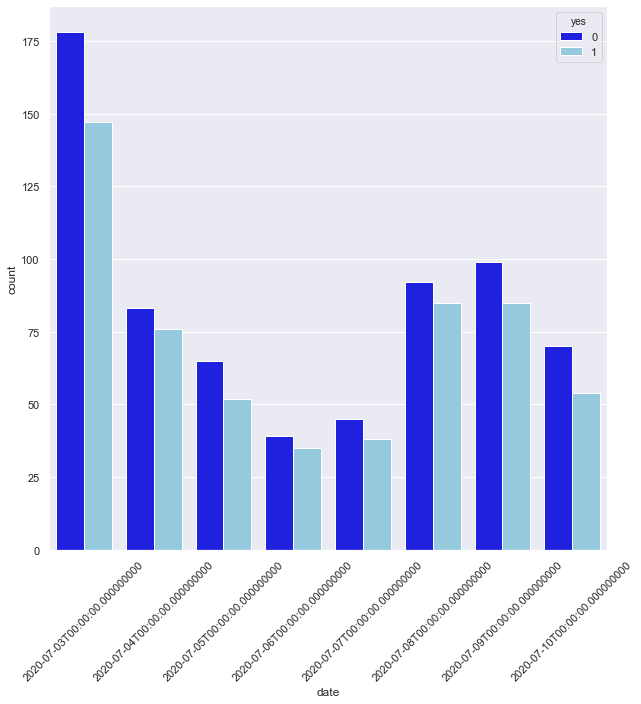

In [32]:
plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="date", palette=["blue", "skyblue"], data=response, hue='yes')
plt.xticks(rotation=45)

bar plot of hour of the experiment
to see if there are more people who said yes or no in a certain hour. Hour 15 had the most number of people online and it is the hour when most respondents gave their responses.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

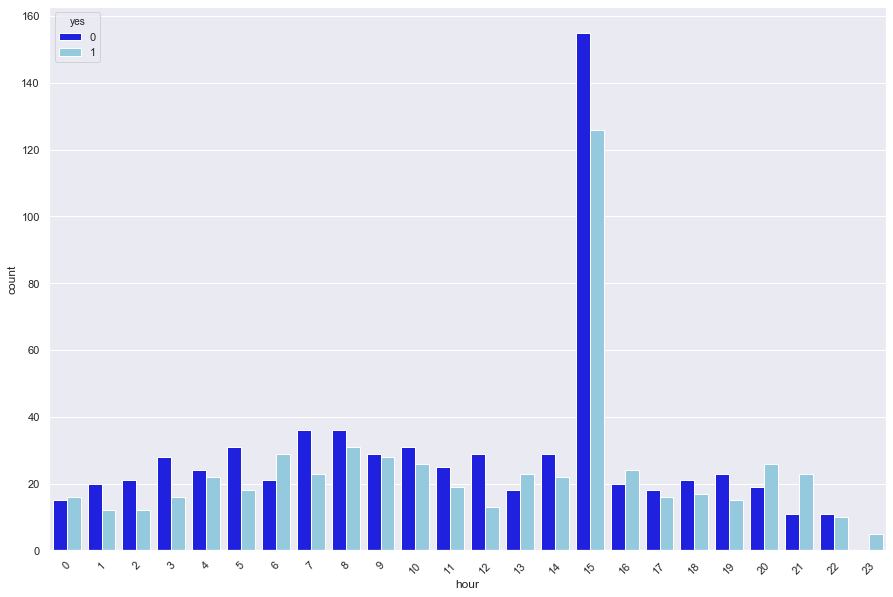

In [33]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="hour", palette=["blue", "skyblue"], data=response, hue='yes')
plt.xticks(rotation=45)

bar plot of OS used during the experiment
to see if there are more people who said yes or no in one platform compared to the other 

(array([0, 1]), <a list of 2 Text xticklabel objects>)

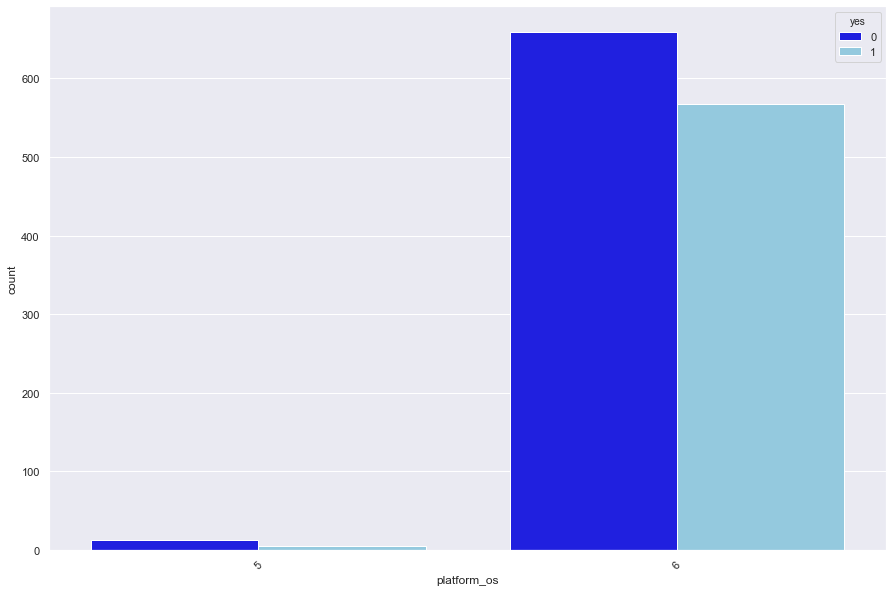

In [34]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="platform_os", palette=["blue", "skyblue"], data=response, hue='yes')
plt.xticks(rotation=45)

# CLASSICAL FREQUENTIST A/B TESTING
The classical tests use p-values or critical values and test statistics to determine the impact of using the SmartAd for advertisement.

The lower the p-value obtained from the data is, the more confident we are that SmartAd has a greater impact. The threshold used to make the decision about whether the p-value is small enough to make the impact of the SmartAd statistically significant is ,alpha, the level of significance chosen by the person conducting the experiment.

Here a significance level of 0.05 is used. It means that if there is no difference between the SmartAd and the dummy ad, and we conducted the experiment many times, 5% of the times we might end up with the wrong decision.

A p-value does not give the size of the effect, that is, if we find that the two types of ads have a different impact, the p-value does not tell us, how much of an impact the SmartAd had. Therefore, we will decide on a practical level of significance to provide a minimum effect size that would tell us if the SmartAd achieved the minimum effect size desired.

compare the distribution of the two groups using binomial distribution
the exposed group has more people who are aware of the lux brand compared to the control group

Text(0, 0.5, 'probability')

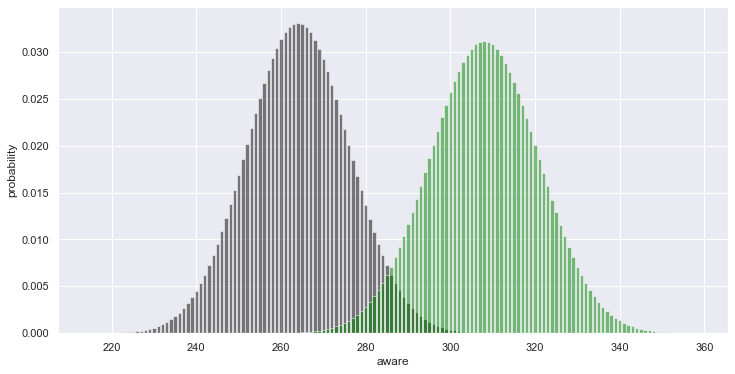

In [35]:
control_aware=control_data['yes'].sum()                   #no of people who are aware of lux in control group
control_total=len(control_data)                    #total number of people in the control group
exposed_aware=exposed_data['yes'].sum()                    #no of people who are aware of lux in exposed group
exposed_total=len(exposed_data)                    #total number of people in exposed group
p_control=control_aware/control_total                    #probability of being in control group
p_exposed=exposed_aware/exposed_total                    #probablity of being in exposed group
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(control_aware-49, control_aware+50, 100)
yA = scs.binom(control_total, p_control).pmf(xA)
ax.bar(xA, yA, alpha=0.5, color='black')
xB = np.linspace(exposed_aware-49, exposed_aware+50, 100)
yB = scs.binom(exposed_total, p_exposed).pmf(xB)
ax.bar(xB, yB, alpha=0.5,color='green')
plt.xlabel('aware')
plt.ylabel('probability')

In [36]:
# control_aware=264                    #no of people who are aware of lux in control group
# control_total=586                    #total number of people in the control group
# exposed_aware=308
# exposed_total=657
# control_cr= 0.450512                   #proportion of yes for control group
# exposed_cr=0.468798                 #proportion of yes for experiment group
# fig, ax = plt.subplots(figsize=(12,6))
# x = np.linspace(control_aware-49, control_aware+50, 100)
# y = scs.binom(control_total, control_cr).pmf(x)
# ax.bar(x, y, alpha=0.5)
# ax.axvline(x=exposed_cr * control_total, c='blue', alpha=0.75, linestyle='--')
# plt.xlabel('aware_of_brand')
# plt.ylabel('probability')

A/B test based on conversion of the bernoulli parameter following a normal distribution
Below, we check if the difference between the conversions in the experiment group and that of the control group are 
statistically significant

In [37]:
baseline_rate = control_aware / control_total  #level of awareness in the control group
practical_significance = 0.02 #user defined, this is the amount of change we need to conclude that there is a difference between the groups
confidence_level = 0.05 #user defined, for a 95% confidence interval, this is the probability of type I error
sensitivity = 0.9 #user defined, this is the power of the test

In [38]:
#Calculate pooled probability
prob_pooled = (control_aware + exposed_aware) / (control_total + exposed_total)

Zero is contained in the interval below therefore based on the confidence interval, we fail to reject the null and conclude that 95% of the times the experiment is run, there is no impact from using the smart ad 

In [39]:
#Calculate pooled standard error and margin of error
se_pooled = math.sqrt(prob_pooled * (1 - prob_pooled) * (1 / control_total + 1 / exposed_total))
#z_score = scs.norm.ppf(1 - confidence_level / 2)
z_score = scs.norm.ppf(1 - confidence_level / 2)
margin_of_error = se_pooled * z_score

#Calculate dhat, the estimated difference between probability of awareness in the experiment and control groups
d_hat = (exposed_aware / exposed_total) - (control_aware / control_total)

#Test if we can reject the null hypothesis
lower_bound = d_hat - margin_of_error
upper_bound = d_hat + margin_of_error
print("The lower bound of the confidence interval is ", round(lower_bound * 100, 2), "%")
print("The upper bound of the confidence interval is ", round(upper_bound * 100, 2), "%")

The lower bound of the confidence interval is  -3.72 %
The upper bound of the confidence interval is  7.38 %


In [40]:
#z_stat=(d_hat-prob_pooled)/se_pooled
#z_stat

Based on the lift, the lower boundary of the difference is less than the 0.05 difference in awareness that has been set here, we also end up concluding that there was no difference from using the smart ad as opposed to the dummy

In [41]:
if practical_significance < lower_bound:
    print("Reject null hypothesis")
else: 
    print("Do not reject the null hypothesis")

Do not reject the null hypothesis


Determine required sample size

In [42]:
effect_size = sm.stats.proportion_effectsize(baseline_rate, baseline_rate + practical_significance)
sample_size = sm.stats.NormalIndPower().solve_power(effect_size = effect_size, power = sensitivity, 
                                               alpha = confidence_level, ratio=1)
print("Required sample size: ", round(sample_size), " per group")

Required sample size:  13051  per group


The samples in each group are less than the minimum required sample size, the company needs to collect more responses or apply a bootstrap. A bootsrap will sample the original dataset with replacement to create new and unique datasets. It assumes that the original dataset is a fairly good reflection of the population as a whole so therefore sampling with replacement roughly simulates random sampling from the population. This will ensure that the null hypothesis is not randomly rejected and could also increase the size of the samples.

In [43]:
ab_summary

,yes,total,rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


The classical A/B test has only taken into account the response column variables and ignored the other variable contained in the data

# SEQUENTIAL A/B TEST

Conditional Sequential Test

In [ ]:
#a=response[(response['experiment']== 'exposed')].reset_index()

In [ ]:
#a['time']=a['date']+':'+a['hour'].astype(str)

In [ ]:
#a.time.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))

In [ ]:
def transform_data(df):
  '''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
    df = df[(df['yes']== 1) | (df['no']== 1)]           #filter to remove non-respondents
    exposed_df=response[(response['experiment']== 'exposed')].reset_index()
    control_df=response[(response['experiment']== 'control')].reset_index()

    return exposed,control

In [ ]:
#@title
#REFERENCE
# A Conditional Sequential Test for the Equality of Two Binomial Proportions
# William Q. Meeker, Jr
# Journal of the Royal Statistical Society. Series C (Applied Statistics)
# Vol. 30, No. 2 (1981), pp. 109-115
class ConditionalSPRT:
    def __init__(self,x,y,t1,alpha=0.05,beta=0.10,stop=None):
        self.x=x
        self.y=y
        self.t1=t1
        self.alpha=alpha
        self.beta=beta
        self.stop=stop

        if t1<=1:
            printLog('warning',"Odd ratio should exceed 1.")
        if (alpha >0.5) | (beta >0.5):
            printLog('warning',"Unrealistic values of alpha or beta were passed."
                     +" You should have good reason to use large alpha & beta values")
        if stop!=None:
            stop=math.floor(n0)

    def comb(n, k):
        return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

    def lchoose(b, j):
        a=[]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            if len(j)<2:
                j=j[0]
        if (type(j) is list) | (isinstance(j,np.ndarray)==True):
            for k in j:
                n=b
                if (0 <= k) & (k<= n):
                    a.append(math.log(comb(n,k)))
                else:
                    a.append(0)
        else:
            n=b
            k=j
            if (0 <= k) & (k<= n):
                a.append(math.log(comb(n,k)))
            else:
                a.append(0)

        return np.array(a)

    def g(x,r,n,t1,t0=1):
        return -math.log(h(x,r,n,t1))+math.log(h(x,r,n,t0))

    def h(x,r,n,t=1):
        return f(r,n,t,offset=ftermlog(x,r,n,t))

    def f(r,n,t,offset=0):
        upper=max(0,r-n)
        lower=min(n,r)
        rng=list(range(upper,lower+1))
        return np.sum(fterm(rng,r,n,t,offset))

    def fterm(j,r,n,t,offset=0):
        ftlog=ftermlog(j,r,n,t,offset)
        return np.array([math.exp(ex) for ex in ftlog])

    def ftermlog(j,r,n,t,offset=0):
        xx=r-j
        lch=lchoose(n,j)
        lchdiff=lchoose(n,xx)
        lg=np.array(j)*math.log(t)
        lgsum=lch+lchdiff
        lgsum2=lgsum+lg
        lgdiff=lgsum2-offset

        return lgdiff

    def logf(r,n,t,offset=0):

        z=f(r,n,t,offset)
        if z>0:
            return math.log(z)
        else:
            return np.nan

    def clowerUpper(r,n,t1c,t0=1,alpha=0.05,beta=0.10):
        offset=ftermlog(math.ceil(r/2),r,n,t1c)
        z=logf(r,n,t1c,logf(r,n,t0,offset)+offset)
        a=-math.log(alpha/(1-beta))
        b=math.log(beta/(1-alpha))
        lower=b
        upper=1+a
        return (np.array([lower,upper])+z)/math.log(t1c/t0)

        l=math.log(self.beta/(1-self.alpha))
        u=-math.log(self.alpha/(1-self.beta))
        sample_size=min(len(x),len(y))
        n=np.array(range(1,sample_size+1))

        if self.stop!=None:
            n=np.array([z for z in n if z<=stop])
        x1=np.cumsum(x[n-1])
        r=x1+np.cumsum(y[n-1])
        stats=np.array(list(map(g,x1, r, n, [t1]*len(x1)))) #recurcively calls g

        clu=list(map(clowerUpper,r,n,[t1]*len(r),[1]*len(r),[alpha]*len(r), [beta]*len(r)))
        limits=[]
        for v in clu:
            inArray=[]
            for vin in v:
                inArray.append(math.floor(vin))
            limits.append(np.array(inArray))
        limits=np.array(limits)

        k=np.where((stats>=u) | (stats<=l))
        cvalues=stats[k]
        if cvalues.shape[0]<1:
            k= np.nan
            outcome='Unable to conclude.Needs more sample.'
        else:
            k=np.min(k)
            if stats[k]>=u:
                outcome=f'Exposed group produced a statistically significant increase.'
            else:
                outcome='Their is no statistically significant difference between two test groups'
        if (stop!=None) & (k==np.nan):
            c1=clowerUpper(r,stop,t1,alpha,beta)
            c1=math.floor(np.mean(c1)-0.5)
            if x1[n0]<=c1:
                truncate_decision='h0'
                outcome='Maximum Limit Decision. The aproximate decision point shows their is no statistically significant difference between two test groups'
            else:
                truncate_decision='h1'
                outcome=f'Maximum Limit Decision. The aproximate decision point shows exposed group produced a statistically significant increase.'
            truncated=stop
        else:
            truncate_decision='Non'
            truncated=np.nan
        return outcome,n, k,l,u,truncated,truncate_decision,x1,r,stats,limits

In [ ]:
 model=ConditionalSPRT(exposed_data['yes'],control_data['yes'],t1=2,alpha=0.05,beta=0.10,stop=None)

In [ ]:
model.comb()

In [ ]:
model.lchoose()

In [ ]:
model.g()

In [ ]:
model.h()

In [ ]:
model.f()

In [ ]:
model.fterm()

In [ ]:
model.ftermlog()

In [ ]:
model.logf()

In [ ]:
model.clowerUpper()

# SEQUENTIAL PROBABILITY RATIO TEST
A sequential probability ratio test uses the same principles of classical hypothesis testing but takes in the data as it arrives and makes a decision, the experiment can be stopped once a positive result is obtained. The SPRT reduces the amount of time it takes to run an experiment. Unlike the classical test, where the experiment has to run its course until the required sample size is achieved, the sequential test can be stopped earlier.

In [ ]:
class SequentialTest:
  def __init__(self,exposed,control,alpha,beta):
    '''
    initialise startup variables
    '''
    self.exposed=exposed
    self.control=control
    self.alpha=alpha
    self.beta=beta
    
    
  
  def stoppingRule(self,p_exposed,p_control):
    '''
    This function should take current observation and return statistical decision made. 
    Consider truncate rule for longer tests
    '''

    a=np.log(self.beta/(1-self.alpha))
    b=np.log((1-self.beta)/self.alpha)
    S=0
    while a<S<b:
        control_aware=control_data['yes'].sum()                   #no of people who are aware of lux in control group
        control_total=len(control_data)                    #total number of people in the control group
        exposed_aware=exposed_data['yes'].sum()                    #no of people who are aware of lux in exposed group
        exposed_total=len(exposed_data)                    #total number of people in exposed group
        p_control=control_aware/control_total                    #probability of being in control group
        p_exposed=exposed_aware/exposed_total                    #probablity of being in exposed group
        llikelihood_exposed=np.log(scs.norm.pmf(exposed.yes,p_exposed)).sum()
        llikelihood_control=np.log(scs.norm.pmf(control.yes,p_control)).sum()
        lrt=llikelihood_control/llikelihood_exposed    
        S=+lrt
        
    if S>=b:
        return "Reject null hypothesis"
    if S<=a:
        return "Fail to reject null hypothesis"
   

  def computeBoundaries(self,):
    '''
    This function shoud compute boundaries 
    '''

  def plotTest(self,):
    '''
    showing the cumulative statistical test (e.g., log probability ratio) and the uper and lower limits.
    '''

  def plotBoundaries(self,):
    '''cumulative sums of exposed successes, bounded by the critical limits.
    '''


In [ ]:
def transform_data(df):
  '''
  segment data into exposed and control groups
  consider that SmartAd runs the experment hourly, group data into hours. 
      Hint: create new column to hold date+hour and use df.column.map(lambda x:  pd.Timestamp(x,tz=None).strftime('%Y-%m-%d:%H'))
  create two dataframes with bernouli series 1 for posetive(yes) and 0 for negative(no)
    Hint: Given engagement(sum of yes and no until current observation as an array) and success (yes countas an array), the method generates random binomial distribution
        #Example
           engagement = np.array([5, 3, 3])
           yes = np.array([2, 0, 3])       
         Output is "[1] 1 0 1 0 0 0 0 0 1 1 1", showing a binary array of 5+3+3 values
         of which 2 of the first 5 are ones, 0 of the next 3 are ones, and all 3 of
         the last 3 are ones where position the ones is randomly distributed within each group.
  '''
  return exposed,control

def plotDataSummary(exposed, control):
  'This function plots cummulated success'

def pretyPrintTestResult(self, test):
  '''This function print final test result. Json format is recommended. For example
  {
    "name": "",
    "engagementCountControl": ,
    "engagementCountExposed": ,
    "positiveCountControl": ,
    "positiveCountExposed": ,
    "ControlSuccessProbability": ,
    "ExposedSuccessProbability": ,
    "basePositiveRate": ,
    "significanceSign": ".",
    "lift": ,
    "oddRatio": ,
    "exactSuccessOddRate":,
    "confidenceIntervalLevel": ,
    "alpha": ,
    "beta": ,
    "power": ,
    "criticalValue": ,
    "lower critical(a)": 
    "upper critical(b)": ,
    "TotalObservation": 
  }'''

In [44]:
######################################
'Define statistical parameters such as alpha, beta, sample size if evan approach is used, odd ratio for SPRT'
alpha=
beta=
#other variables here
'Compute statistical lower and upper decision points such as a and b'
a=
b=
#other variables here

##data processing here
exposed,control=transform_data(data)
##plot data summary
plotDataSummary(exposed,control)

'Perform test. Loop over each of data entry and perform test. Accumulate result into dataframe and print out test journey'
test=SequentialTest(...)

'Print test result.'
pretyPrintTestResult(resultObject)

SyntaxError: invalid syntax (<ipython-input-44-5988c6d81a69>, line 3)

# Machine Learning A/B Testing
Classical and sequential tests have not taken into account the variables collected in the dataset, they focused on the respones collected to detrmine the impact of the SmartAd. However, there could be other factors about the individuals that lead the to choose yes or no. These factors are collected as variables in the dataset.

For example, the respondents, respond at different hours, using different browsers, devices and different operating systems.

This analysis will look at the factors that are driving an individual to choose yes or no in the survey and determine if there is an impact from using a SmartAd over a dummy ad.

The users in the control will be labeled as 0

The users in the exposed group will be labeled as 1

In [58]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
#from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score,RepeatedKFold,GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report,roc_curve,auc,roc_auc_score
from xgboost import plot_tree


C:\Users\Stella\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [45]:
response.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1,0
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0,1
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1,0
4,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,1


In [46]:

# exp_dict = {
#   "exposed": "1",
#   "control": "0"
#   }

# response['Tag'] = response['experiment'].map(exp_dict)
# response.head(10)

In [47]:
#relabel experiment column to values 0 and 1
#0-control
#1-exposed

response['experiment'] = np.where(response['experiment']=="exposed", '1', '0')
response['experiment']=pd.to_numeric(response['experiment'])
#response.head()

In [48]:
#drop the no column
#drop auction_id column and date columns
#rename yes column to awareness,
#0-does not know brand
#1-knows brand
response=response.drop(['no','auction_id','date'],axis=1)
response=response.rename(columns={"yes": "awareness"})
response.head()

,experiment,hour,device_make,platform_os,browser,awareness
0,1,2,E5823,6,Chrome Mobile WebView,0
1,1,16,Generic Smartphone,6,Chrome Mobile,1
2,1,8,Generic Smartphone,6,Chrome Mobile,0
3,0,4,Samsung SM-A202F,6,Facebook,1
4,0,15,Generic Smartphone,6,Chrome Mobile,0


Split Data by browser and platform_os for versioning


In [49]:
response.platform_os.unique()

array([6, 5], dtype=int64)

In [50]:
response.browser.unique()

array(['Chrome Mobile WebView', 'Chrome Mobile', 'Facebook',
       'Samsung Internet', 'Mobile Safari', 'Chrome',
       'Mobile Safari UI/WKWebView', 'Chrome Mobile iOS'], dtype=object)

In [51]:
grouped_browser = response.groupby(response.platform_os)
# grouped_browser.head()
Chrome_Mobile_Webview = grouped_browser.get_group(6).reset_index(drop=True)
#Chrome_Mobile_Webview.to_csv("data/platform6.csv")

In [52]:
#encode the categorical variables using label encoding

lb_make = LabelEncoder()
response['device_make'] = lb_make.fit_transform(response['device_make'])
response['browser'] = lb_make.fit_transform(response['browser'])
response.head()

,experiment,hour,device_make,platform_os,browser,awareness
0,1,2,4,6,2,0
1,1,16,13,6,1,1
2,1,8,13,6,1,0
3,0,4,43,6,4,1
4,0,15,13,6,1,0


In [53]:
#using all the data before the split above
#split the data into train, validation and test
train, validate, test = np.split(response.sample(frac=1, random_state=42), 
                       [int(.7*len(response)), int(.9*len(response))])

In [54]:
#separate the response variable from the dataset
y_train,y_validation,y_test=(train['awareness'],validate['awareness'],test['awareness'])
x_train,x_validation,x_test=(train.drop(['awareness'], axis=1),validate.drop(['awareness'], axis=1),test.drop(['awareness'], axis=1))

In [55]:
# #Preliminary model evaluation using default parameters

# #Creating a dict of the models
# model_dict = {'Logistic Regression' : LogisticRegression(random_state=3),
#               'Random Forest': RandomForestClassifier(random_state=3),
#               'XGBoost': XGBClassifier()}


# #Function to get the scores for each model in a df
# def model_score_df(model_dict):   
#     model_name, ac_score_list, p_score_list, r_score_list, f1_score_list = [], [], [], [], []
#     for k,v in model_dict.items():   
#         model_name.append(k)
#         v.fit(x_train, y_validation)
#         y_pred = v.predict(x_validation)
#         ac_score_list.append(accuracy_score(y_validation, y_pred))
#         p_score_list.append(precision_score(y_validation, y_pred, average='macro'))
#         r_score_list.append(recall_score(y_validation, y_pred, average='macro'))
#         f1_score_list.append(f1_score(y_validation, y_pred, average='macro'))
#         model_comparison_df = pd.DataFrame([model_name, ac_score_list, p_score_list, r_score_list, f1_score_list]).T
#         model_comparison_df.columns = ['model_name', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score']
#         model_comparison_df = model_comparison_df.sort_values(by='f1_score', ascending=False)
#     return model_comparison_df

# model_score_df(model_dict)

Logistic Regression

In [59]:
#Check the number of values in each class of the response variable
#the classes are slightly imbalanced
response.awareness.value_counts()

0    671
1    572
Name: awareness, dtype: int64

In [60]:
clf_log = LogisticRegression(random_state=0)
log_result=clf_log.fit(x_train,y_train)
predictions_log=clf_log.predict(x_validation)

Performance of Logistic regression on validation set

In [61]:
score = clf_log.score(x_validation, y_validation)
score

0.5564516129032258

Logistic Regression using 5-fold cross validation

Cross validation splits the data into subsets and applies the model to each subset of data. The accuracy of each model is reported. Here we obtain the mean and standard deviation of the accuracies of all the models run by the cross validation.
Splitting the dataset into 10 subsets and running the model 5 times will return 50 results, the final score of 0.507 is the mean of the 50 values.

This value is lower than the value of the accuracy 0f 0.556 obtained without cross validation. It is expected that repeating the procedure many times should result in a more stable score if the trials are independent.
A grid search also uses cross validation to determine the optimal parameters to use in a model.

In [62]:
#5-fold cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

Performance of logistic regression with  cross validation

In [63]:
score = cross_val_score(clf_log, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(score), np.std(score)))

Accuracy: 0.507 (0.046)


In [64]:
#using gridsearch and cross validation to fit model
#the gridsearch produces a similar model to what was fit originally
#penalty=['l1','l2']
C=np.logspace(0,4,10)
log_hyperparameters=dict(C=C)
clf_log_cv=GridSearchCV(clf_log,log_hyperparameters,cv=5,verbose=0)
clf_log_cv.fit(x_train,y_train)
clf_log_cv_predictions=clf_log_cv.predict(x_validation)
clf_log_cv.score(x_validation, y_validation)

0.5564516129032258

In [65]:
  
log_cnm=confusion_matrix(y_validation, predictions_log)
print('log_results') 
print ('Accuracy Score :',accuracy_score(y_validation, predictions_log))
print("Precision:",precision_score(y_validation, predictions_log))
print("Recall:",recall_score(y_validation, predictions_log))
#print ('Report : ')
#print (classification_report(y_validation, predictions_log))

log_results
Accuracy Score : 0.5564516129032258
Precision: 0.6086956521739131
Recall: 0.12173913043478261


Visualize confusion matrix as heat map

Text(0.5, 12.5, 'Predicted label')

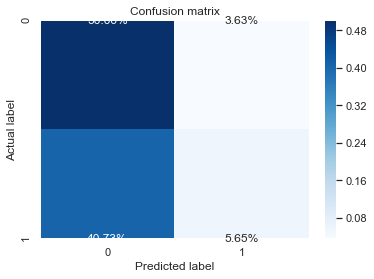

In [66]:
# create heatmap
sns.heatmap(log_cnm/np.sum(log_cnm), annot=True ,fmt='.2%', cmap='Blues')
ax.xaxis.set_label_position("top")
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


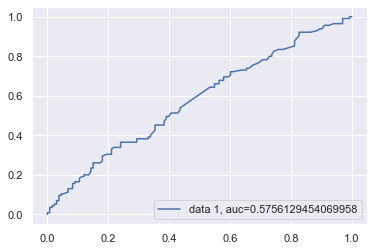

In [67]:
y_valid_proba = clf_log.predict_proba(x_validation)[::,1]
fpr, tpr, _ = roc_curve(y_validation,  y_valid_proba)
auc = roc_auc_score(y_validation, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

From the results of the accuracy score, precision, recall and ROC curve, the logistic regression has not done very well in predicting the classes and we can try fitting another model to compare the results.

Before fitting another model, we look at the model coefficients produced by the logistic regression and rank feature importance based on the logistic regression:
The coefficient due to the experiment is 0.016858 indicating that there is a slight increase in awareness due to conducting the experiment, that is, administering the smartad.
The plot of feature importance shows that the platform os was the most important feature driving the responses.

In [68]:
#coefficients
pd.DataFrame({"Feature":x_train.columns.tolist(),"Coefficients":clf_log.coef_[0]})

,Feature,Coefficients
0,experiment,0.016858
1,hour,0.011921
2,device_make,0.002048
3,platform_os,0.407082
4,browser,-0.000590


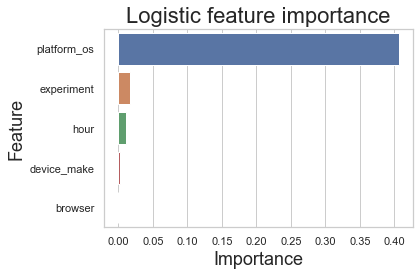

In [92]:
# get importance
importances = clf_log.coef_[0]
labels = response.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns=["feature", "importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False, )
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

# image formatting
axis_fs = 18  # fontsize
title_fs = 22  # fontsize
sns.set(style="whitegrid")

ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance', fontsize=axis_fs)
ax.set_ylabel('Feature', fontsize=axis_fs)  # ylabel
ax.set_title('Logistic feature importance', fontsize=title_fs)

plt.tight_layout()
plt.savefig("feature_importance.png", dpi=120)
plt.show()

Random Forest Classification

In [70]:
# #Hyperparameter tuning using gridsearch and cross validation
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# clf_rf = RandomForestClassifier()
# # Instantiate the grid search model
# clf_rf_cv = GridSearchCV(estimator = clf_rf, param_grid = param_grid, 
#                           cv = 5, n_jobs = -1, verbose = 2)
# clf_rf_cv.fit(x_train,y_train)
# clf_rf_cv_predictions=clf_rf_cv.predict(x_validation)
# clf_rf_cv.score(x_validation, y_validation)

In [72]:
#clf_rf_cv.fit(x_train,y_train)

In [73]:
#Random Forest without gridsearch
clf_rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False)
rf_result=clf_rf.fit(x_train,y_train)
predictions_rf=clf_rf.predict(x_validation)
clf_rf.score(x_validation, y_validation)

0.5443548387096774

In [74]:
score = cross_val_score(clf_rf, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(score), np.std(score)))

Accuracy: 0.507 (0.045)


In [75]:
rf_cnm=confusion_matrix(y_validation, predictions_rf)
print('log_results') 
print ('Accuracy Score :',accuracy_score(y_validation, predictions_rf))
print("Precision:",precision_score(y_validation, predictions_rf))
print("Recall:",recall_score(y_validation, predictions_rf))

log_results
Accuracy Score : 0.5443548387096774
Precision: 0.509090909090909
Recall: 0.48695652173913045


Text(0.5, 12.5, 'Predicted label')

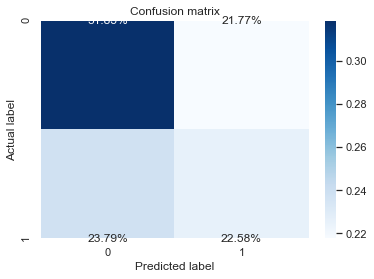

In [76]:
# create heatmap
sns.heatmap(rf_cnm/np.sum(rf_cnm), annot=True ,fmt='.2%', cmap='Blues')
ax.xaxis.set_label_position("top")
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


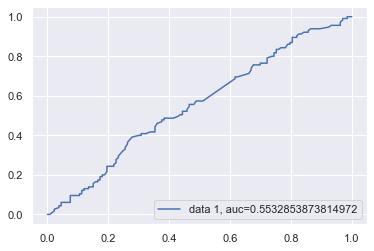

In [77]:
y_valid_proba = clf_rf.predict_proba(x_validation)[::,1]
fpr, tpr, _ = roc_curve(y_validation,  y_valid_proba)
auc = roc_auc_score(y_validation, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

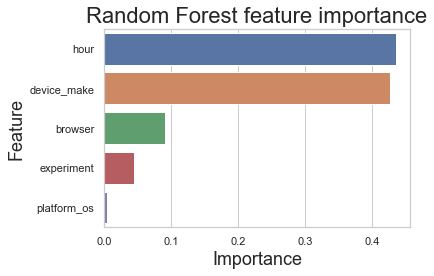

In [89]:
# get importance
importances = clf_rf.feature_importances_
labels = response.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns=["feature", "importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False, )
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

# image formatting
axis_fs = 18  # fontsize
title_fs = 22  # fontsize
sns.set(style="whitegrid")

ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance', fontsize=axis_fs)
ax.set_ylabel('Feature', fontsize=axis_fs)  # ylabel
ax.set_title('Random Forest feature importance', fontsize=title_fs)

plt.tight_layout()
plt.savefig("feature_importance.png", dpi=120)
plt.show()

In [79]:
# # Extract single tree
# estimator = clf_rf.estimators_[1]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(estimator, out_file='tree.dot', 
#                 feature_names = x_train.columns,
#                 class_names = np.array(["0","1"]),
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

The .png file of the tree can be found in the folder and it shows the most important feature driving the results is the hour. The performance of the random forest model is slightly better than the logistic regression, in particular the precision greatly improves when using the random forest.

XGBOOST CLASSIFIER

In [80]:
#XGBOOST without gridsearch
clf_xgb = XGBClassifier(booster='gbtree',
                                     colsample_bytree=0.5,
                                     importance_type='gain',
                                     num_parallel_tree=10,
                                     learning_rate=0.8, max_delta_step=1,
                                     max_depth=3, num_features=100,
                                     n_estimators=600,num_round=5,
                                     reg_lambda=1, alpha=0,
                                     silent=True, subsample=0.5,
                                     tree_method='hist',seed=440,
                                     validate_parameters=False,
                                     verbosity=1)
xgb_result=clf_xgb.fit(x_train,y_train)
predictions_xgb=clf_xgb.predict(x_validation)
clf_xgb.score(x_validation, y_validation)

0.5564516129032258

In [81]:
#score = cross_val_score(clf_xgb, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
#print('Accuracy: %.3f (%.3f)' % (np.mean(score), np.std(score)))

In [82]:
xgb_cnm=confusion_matrix(y_validation, predictions_xgb)
print('log_results') 
print ('Accuracy Score :',accuracy_score(y_validation, predictions_xgb))
print("Precision:",precision_score(y_validation, predictions_xgb))
print("Recall:",recall_score(y_validation, predictions_xgb))

log_results
Accuracy Score : 0.5564516129032258
Precision: 0.5238095238095238
Recall: 0.4782608695652174


Text(0.5, 12.5, 'Predicted label')

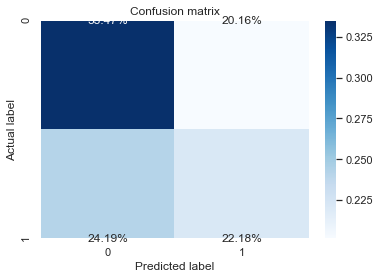

In [83]:
# create heatmap
sns.heatmap(xgb_cnm/np.sum(xgb_cnm), annot=True ,fmt='.2%', cmap='Blues')
ax.xaxis.set_label_position("top")
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


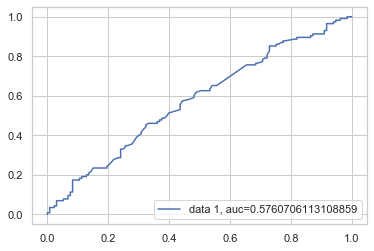

In [84]:
y_valid_proba = clf_xgb.predict_proba(x_validation)[::,1]
fpr, tpr, _ = roc_curve(y_validation,  y_valid_proba)
auc = roc_auc_score(y_validation, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

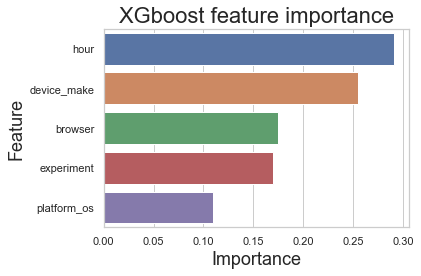

In [87]:
# get importance
importances = clf_xgb.feature_importances_
labels = response.columns
feature_df = pd.DataFrame(list(zip(labels, importances)), columns=["feature", "importance"])
feature_df = feature_df.sort_values(by='importance', ascending=False, )
# summarize feature importance
#for i,v in enumerate(importance):
#    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
#plt.show()

# image formatting
axis_fs = 18  # fontsize
title_fs = 22  # fontsize
sns.set(style="whitegrid")

ax = sns.barplot(x="importance", y="feature", data=feature_df)
ax.set_xlabel('Importance', fontsize=axis_fs)
ax.set_ylabel('Feature', fontsize=axis_fs)  # ylabel
ax.set_title('XGboost feature importance', fontsize=title_fs)

plt.tight_layout()
plt.savefig("feature_importance.png", dpi=120)
plt.show()

In [86]:
# # plot single tree
# plot_tree(clf_xgb, num_trees=1, rankdir='LR')
# fig = plt.gcf()
# fig.set_size_inches(150, 100)
# fig.savefig('tree.png')
# plt.show()

The random forest model performs better than the xgboost and would be the preferred model.

In all of the three models, the experiment has not featured among the top important features driving the awareness of the brand therefore the smartAd has not had a significant impact in the responses provided.